# Import Libaries

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import os
import csv, datetime, uuid, time

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

# Reproducibility

In [108]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Load & sort data

In [109]:
ticker = "AAPL"
df = pd.read_csv(f'..\..\data\processed\{ticker}_processed_data_full.csv', parse_dates=['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
print(df.head(), df.columns)

        Date      Close       High        Low       Open     Volume     Target
0 2017-01-03  26.862425  26.904054  26.540955  26.781479  115127600  26.832355
1 2017-01-04  26.832355  26.945681  26.769912  26.793039   84472400  26.968815
2 2017-01-05  26.968815  27.026633  26.783795  26.809235   88774400  27.269468
3 2017-01-06  27.269468  27.327287  26.936434  27.008128  127007600  27.519241
4 2017-01-09  27.519241  27.621002  27.276405  27.278717  134247600  27.546997 Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target'], dtype='object')


# Feature Engineering

## One-Day Return
- Is simply the percentage change in price from one day to the next
- Helps pick up on the rate of change in the market rather than raw price levels
- Scale‐invariance: Returns normalize price changes into a small, stable range so the model isn’t thrown off by the stock’s overall price drift.
- Momentum & mean‐reversion: Returns capture serial correlation, helping the network spot short‐lived trends and reversals.
- Stationarity: Returns have steadier statistics over time than raw prices, which makes neural‐net training more stable.

In [110]:
df['Return'] = df['Close'].pct_change()
df = df.dropna(subset=['Return'])   # drop first row

# 10-day Exponential Moving Average (EMA-10)
- Emphasizes recent moves: unlike a simple moving average, an EMA gives exponentially more weight to the latest days, so it reacts faster to new trends.
- Filters noise: it smooths out day-to-day volatility so your model can see the underlying short-term trend more clearly.
- Captures momentum: crossing patterns (e.g. price above vs. below its EMA) are classic signals for up- or down-momentum.

In [111]:
df["EMA10"] = df["Close"].ewm(span=10, adjust=False).mean()

# Drop the initial NaNs from the EMA calculation
df = df.dropna(subset=["EMA10"]).reset_index(drop=True)

# Chronological 60 / 20 / 20 split

In [112]:
n       = len(df)
i_train = int(0.6  * n)    # first 60% → train
i_val   = int(0.8  * n)    # next 20% → val
# last 20% → test

train_df = df.iloc[:i_train].copy()
val_df   = df.iloc[i_train:i_val].copy()
test_df  = df.iloc[i_val:].copy()


# Scale Features

In [113]:
feature_cols = ['Close', 'Return', 'Volume', 'EMA10'] # can be modified
target_col   = "Target"

scaler = StandardScaler().fit(train_df[feature_cols])
X_tr = scaler.transform(train_df[feature_cols])
X_va = scaler.transform(val_df[feature_cols])
X_te = scaler.transform(test_df[feature_cols])

y_tr = train_df[target_col].values
y_va = val_df[target_col].values
y_te = test_df[target_col].values

# Create Sliding Windows

In [114]:
def make_windows(X, y, W):
    Xs, ys = [], []
    for i in range(W, len(X)):
        Xs.append(X[i-W:i].flatten())  # flatten (W × n_features) → vector
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 20   # 20-day look-back
X_train, y_train = make_windows(X_tr, y_tr, window_size)
X_val,   y_val   = make_windows(X_va, y_va, window_size)
X_test,  y_test  = make_windows(X_te, y_te, window_size)

# Define DNN

In [120]:
description = "Added EMA10" # for logging
layers = 64
dropout = "N/A"
learning_rate = "N/A"

model = Sequential([
    Dense(layers, activation="relu", input_shape=(window_size*len(feature_cols),)),
    Dense(1)   # single-value regression output
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)
model.summary()
num_params = model.count_params() # for logging

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,249 (20.50 KB)

 Trainable params: 5,249 (20.50 KB)

 Non-trainable params: 0 (0.00 B)

# Train with early-stopping

In [116]:
start_time = time.time() # for logging

batch_size_input = 32

es = EarlyStopping(
    monitor="val_rmse",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size_input,
    callbacks=[es],
    verbose=2
)

train_time = round(time.time() - start_time, 2) # for logging
epochs_run = len(history.history["loss"]) # for logging 
val_rmse   = history.history["val_rmse"][-1] # for logging
train_rmse = history.history["rmse"][-1] # for logging

Epoch 1/50
38/38 - 1s - 25ms/step - loss: 5682.5918 - rmse: 75.3830 - val_loss: 18566.3027 - val_rmse: 136.2582
Epoch 2/50
38/38 - 0s - 3ms/step - loss: 4639.2563 - rmse: 68.1121 - val_loss: 12537.9814 - val_rmse: 111.9731
Epoch 3/50
38/38 - 0s - 3ms/step - loss: 3360.6794 - rmse: 57.9714 - val_loss: 6226.7197 - val_rmse: 78.9096
Epoch 4/50
38/38 - 0s - 3ms/step - loss: 2140.2839 - rmse: 46.2632 - val_loss: 1746.1981 - val_rmse: 41.7875
Epoch 5/50
38/38 - 0s - 3ms/step - loss: 1304.8999 - rmse: 36.1234 - val_loss: 181.9957 - val_rmse: 13.4906
Epoch 6/50
38/38 - 0s - 3ms/step - loss: 912.5972 - rmse: 30.2092 - val_loss: 444.4506 - val_rmse: 21.0820
Epoch 7/50
38/38 - 0s - 3ms/step - loss: 769.3942 - rmse: 27.7380 - val_loss: 913.2097 - val_rmse: 30.2194
Epoch 8/50
38/38 - 0s - 3ms/step - loss: 703.3294 - rmse: 26.5204 - val_loss: 1097.2261 - val_rmse: 33.1244
Epoch 9/50
38/38 - 0s - 3ms/step - loss: 656.0876 - rmse: 25.6142 - val_loss: 1126.9902 - val_rmse: 33.5707
Epoch 10/50
38/38 - 0

# Evaluate on test set

In [117]:
test_loss, test_rmse = model.evaluate(X_test, y_test, verbose=0) # for logging
print(f"🚀 Test RMSE: {test_rmse:.4f}")

🚀 Test RMSE: 28.2789


# Log your experiment

In [118]:
exp_id = uuid.uuid4().hex[:8]
run_date = datetime.date.today()

exp_dir  = Path.cwd() / "experiments"
csv_path = exp_dir / f"{ticker}_experiments.csv"

with csv_path.open("a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        exp_id,
        run_date,
        description,
        window_size,
        feature_cols,
        layers,
        dropout, 
        learning_rate,
        batch_size_input,
        epochs_run,
        num_params,
        train_time, 
        train_rmse,                
        val_rmse,
        test_rmse
    ])
print(f"Logged experiment {exp_id}")

Logged experiment ffd0fa45


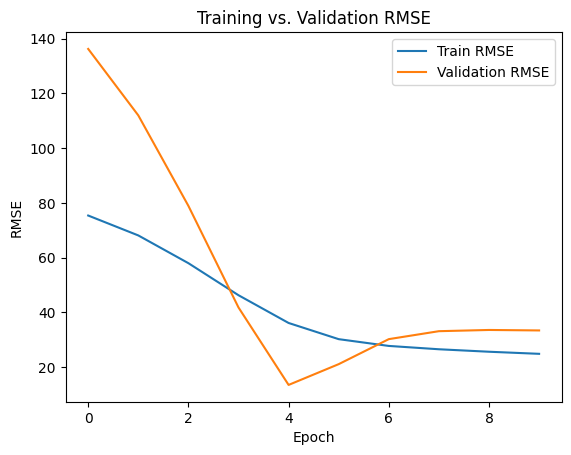

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


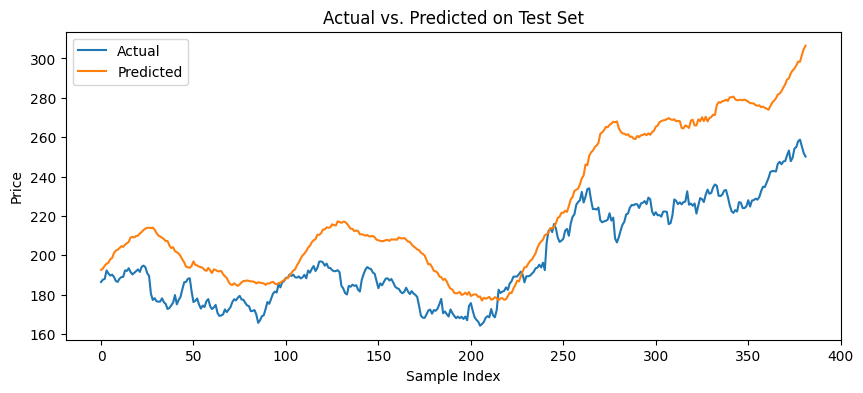

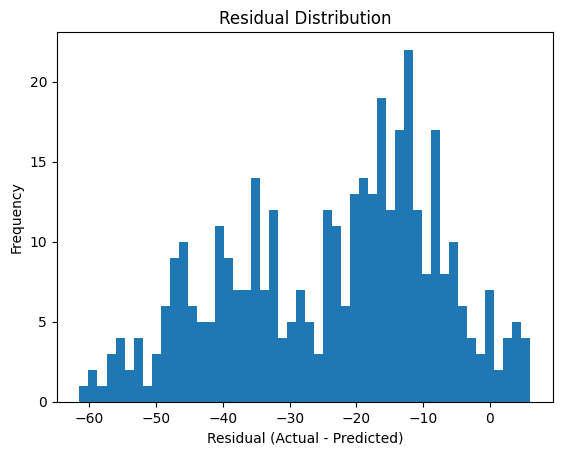

In [ ]:
# 1. Plot training vs. validation RMSE over epochs
plt.figure()
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training vs. Validation RMSE')
plt.legend()
plt.show()

# 2. Plot actual vs. predicted on the test set
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted on Test Set')
plt.legend()
plt.show()
